Прогнозирование акций Лукойл

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
import seaborn as sns
# Рисовать графики сразу же
%matplotlib inline

import os
print ("Ok")

Ok


In [2]:
#Загружаем датафрейм
frame = pd.read_csv('Gosloto_6x45_20200927.csv', header=0, sep=',')

In [3]:
# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz', 'jackpot'], axis=1).astype(float)

<AxesSubplot:>

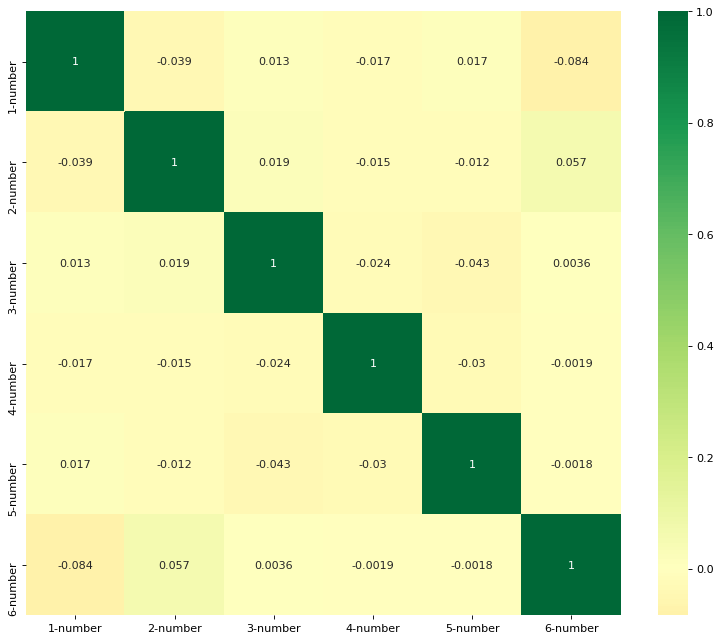

In [4]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(frame.corr(), xticklabels=frame.corr().columns, yticklabels=frame.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [5]:
frame.describe()

,1-number,2-number,3-number,4-number,5-number,6-number
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,23.130000,23.134000,23.168000,22.832000,23.857000,22.525000
std,13.311961,12.988254,12.787545,13.265208,13.292752,12.701918
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,23.000000,23.000000,23.000000,23.000000,24.000000,22.000000
75%,35.000000,35.000000,34.000000,35.000000,36.000000,34.000000
max,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


In [7]:
a = frame["1-number"].to_numpy()
b = frame["2-number"].to_numpy()
c = frame["3-number"].to_numpy()
d = frame["4-number"].to_numpy()
e = frame["5-number"].to_numpy()
f = frame["6-number"].to_numpy()
allnum = np.array([])
# for numa in a:
#     np.append(allnum, [numa])
con = np.stack([a, b, c,d,e,f], axis=1)
con_r = con.reshape(6000,)

In [11]:
start = 0 #С какой точки начинаем
step = allnum.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = list(allnum.columns)
plt.plot(allnum[start:start+step, 1],
          label="результат")
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

**Функция загрузки данных**

In [62]:
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()

  #Берём только те каналы, которые указаны в аргументе функции
  resData = data[:,Channels]
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)
#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производнуюa
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):

  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T

  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)

  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])

  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]

  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [64]:
#Формируем параметры загрузки данных
xLen = 300 #Анализируем по 300 прошедшим точкам
stepsForward = 1 #Предсказываем на 1 шаг вперёд
xChannels = (con_r) #Используемвсе входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 0 #Нормируем входные каналы стандартным распределением
yNormalization = 0#Нормируем выходные каналы стандартным распределением
valLen = 30000 #Используем 30.000 записей для проверки0
returnFlatten = 1 #Вернуть одномерные вечеторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = \
    getXTrainFromTimeSeries(con_r, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

IndexError: arrays used as indices must be of integer (or boolean) type

In [2]:
import sys
def show_sizeof(x, level=0):
    print ("\t" * level, x.__class__, sys.getsizeof(x), x)
    if hasattr(x, '__iter__'):
        if hasattr(x, 'items'):
            for xx in x.items():
                show_sizeof(xx, level + 1)
        else:
            for xx in x:
                show_sizeof(xx, level + 1)
show_sizeof(None)
show_sizeof(3)
show_sizeof(2**63)
show_sizeof(102947298469128649161972364837164)
show_sizeof(918659326943756134897561304875610348756384756193485761304875613948576297485698417)

 <class 'NoneType'> 16 None
 <class 'int'> 28 3
 <class 'int'> 36 9223372036854775808
 <class 'int'> 40 102947298469128649161972364837164
 <class 'int'> 60 918659326943756134897561304875610348756384756193485761304875613948576297485698417
